In [1]:

import os
import cv2
import nibabel as nib
import numpy as np
from PIL import Image
from scipy.ndimage import gaussian_filter
from tqdm import tqdm
from matplotlib import pyplot as plt
import random

def pseudo_color_to_rgb_array(image_slice: np.ndarray, colormap: int = cv2.COLORMAP_RAINBOW):
    """
    将单通道的灰度数组转换为伪彩色数组(BGR格式)

    参数：
        image_slice: 输入的灰度图像数组(2D, dtype=np.uint8, 范围0-255)
        colormap: OpenCV的颜色映射类型,默认为JET

    返回：
        pseudo_color: 伪彩色图像数组(3D, shape=[3,H,W], dtype=np.uint8)
    """
    assert len(image_slice.shape) == 2, "输入必须是单通道灰度数组(2D)"

    # 应用伪彩色映射(例如：COLORMAP_JET)
    pseudo_color = cv2.applyColorMap(image_slice, colormap)

    # 将 BGR 格式转换为 RGB 格式
    rgb_img = cv2.cvtColor(pseudo_color, cv2.COLOR_BGR2RGB)

    # 调整数组维度为 C×W×H(通道在前)
    # 原始维度为 (H, W, C)，转置为 (C, W, H)
    # chw_array = np.transpose(rgb_img, (2, 1, 0))

    return rgb_img

# 通过窗宽窗位调整图像


def window_image(image, window_center, window_width):
    """
    根据窗宽窗位调整图像
    :param image: 输入图像
    :param window_center: 窗位
    :param window_width: 窗宽
    :return: 调整后的图像
    """
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    return window_image

# 选择标准化方法：


def normalize_image(slice_data, method='minmax'):
    if method == 'minmax':
        # 将数据标准化到[0, 1]之间
        MIN_BOUND = 0
        MAX_BOUND = np.max(slice_data)
        slice_data[slice_data > MAX_BOUND] = MAX_BOUND
        slice_data[slice_data < MIN_BOUND] = MIN_BOUND
        slice_data = (slice_data - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
        # slice_data = (slice_data - np.min(slice_data)) / \
        #     (np.max(slice_data) - np.min(slice_data))
    elif method == 'zscore':
        # 使用均值和标准差进行标准化
        slice_data = (slice_data - np.mean(slice_data)) / np.std(slice_data)
    return slice_data


def crop_nonzero_region(img):
    """
    裁剪图片中的非全零区域
    参数:
      img: numpy 数组，支持2D或3D数据
    返回:
      裁剪后的图片
    """
    # 使用 np.nonzero() 获取所有非零元素的索引
    nonzero_indices = np.nonzero(img)

    # 如果图像全为零，则直接返回原图
    if len(nonzero_indices[0]) == 0:
        return img

    # 对于每个维度，找到最小和最大的索引
    min_indices = [np.min(idx) for idx in nonzero_indices]
    max_indices = [np.max(idx) for idx in nonzero_indices]

    # 根据数据维度进行裁剪
    if img.ndim == 2:
        cropped = img[min_indices[0]:max_indices[0] +
                      1, min_indices[1]:max_indices[1]+1]
    elif img.ndim == 3:
        cropped = img[min_indices[0]:max_indices[0]+1,
                      min_indices[1]:max_indices[1]+1,
                      min_indices[2]:max_indices[2]+1]
    else:
        raise ValueError("不支持的数据维度: {}".format(img.ndim))

    return cropped




In [2]:
# 加载文件
nii_image_dir = '/home/kmh/Ependymoma/sub001/'
# nii_image_dir = '/home/kmh/Ependymoma/sub391/'

# 列出目录下的所有文件
nii_files = os.listdir(nii_image_dir)
print("NIfTI files in the directory: ", nii_files)
seg_nii = nib.load(f'{nii_image_dir}/T1SC_roi.nii.gz')
image_nii = nib.load(f'{nii_image_dir}/T1SC.nii')
seg_data = seg_nii.get_fdata()
image_data = image_nii.get_fdata()

NIfTI files in the directory:  ['T1GC.nii', 'T1SC.nii', 'YZ.nii', 'T1SC_roi.nii.gz', 'T1ZC.nii', 'T1S.nii', 'T2S.nii', 'T2Z.nii', 'T2S_roi.nii.gz']


Processing slice 5/11


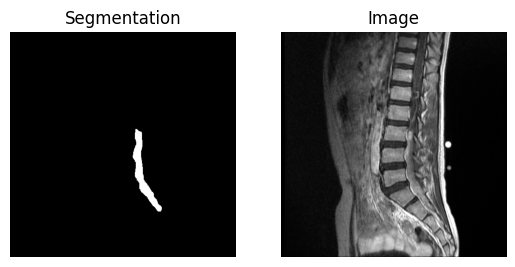

Processing slice 6/11


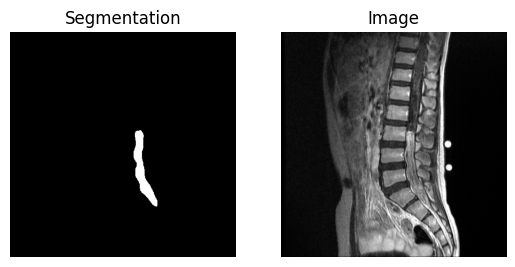

In [6]:
# nii切片
# step设置为1
show_slices = [4, 5]
for i in range(0, seg_data.shape[2], 1):
    if i not in show_slices:
        continue
    print(f'Processing slice {i+1}/{seg_data.shape[2]}')
    seg_slice = np.rot90(seg_data[:, :, i])
    seg_slice = seg_slice.astype(np.uint8)
    # 核心区
    seg_slice[seg_slice == 1] = 1
    # 没有3出现
    seg_slice[seg_slice == 3] = 1
    # 增强区
    seg_slice[seg_slice == 4] = 1
    # 水肿
    seg_slice[seg_slice == 2] = 0
    # if np.sum(seg_slice == 1) < 2:
    #     continue
    # if seg_slice.max() == 0:
        # continue
    seg_slice = (seg_slice * 255).astype(np.uint8)
    image_slice = np.rot90(image_data[:, :, i])
    image_slice = normalize_image(image_slice, 'minmax')
    # image_slice = window_image(image_slice, 300, 1500)
    lower, upper = np.percentile(
        image_slice[image_slice > 0], [0.5, 99.5])
    image_slice = np.clip(image_slice, lower, upper)
    image_slice = ((image_slice - lower) /
                   (upper - lower) * 255.0).astype(np.uint8)
    # seg_slice = np.clip(seg_slice, lower, upper)
    # image_slice = cv2.normalize(
    #     image_slice, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    # 去噪
    # image_slice = cv2.fastNlMeansDenoising(image_slice, h=10, templateWindowSize=5, searchWindowSize=21)
    image_shape = image_slice.shape
    # rows, cols = np.where(image_slice > 0)
    # row_low, row_high = np.percentile(rows, [0.5, 99.5])
    # col_low, col_high = np.percentile(cols, [0.5, 99.5])
    # row_low, row_high = int(row_low), int(row_high)
    # col_low, col_high = int(col_low), int(col_high)
    # image_slice = image_slice[row_low:row_high,
    #                           col_low:col_high]
    # seg_slice = seg_slice[row_low:row_high, col_low:col_high]
    # 针对列方向计算裁剪范围（第2个维度）
    # min_col = np.min(nonzero_indices[1]) if nonzero_indices[1].size > 0 else 0
    # max_col = np.max(nonzero_indices[1]) if nonzero_indices[1].size > 0 else image_slice.shape[1]-1
    # # 行方向保持完整（不裁剪）
    # min_row = 0
    # max_row = image_slice.shape[0]
    # # 执行裁剪
    # image_slice = image_slice[min_row:max_row, min_col:max_col+1]
    # seg_slice = seg_slice[min_row:max_row, min_col:max_col+1]
    # clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8, 8))
    # image_slice = clahe.apply(image_slice)
    # blurred = cv2.GaussianBlur(image_slice, (5, 5), 1.0)
    # image_slice = cv2.addWeighted(
    #     image_slice, 1.5, blurred, -0.5, 0)
    seg_img = Image.fromarray(seg_slice, mode='L').resize(
        image_shape, Image.NEAREST)
    image_img = Image.fromarray(image_slice).resize(
        image_shape, Image.BICUBIC)
    # 展示图像
    plt.subplot(1, 2, 1)
    plt.imshow(seg_img, cmap='gray')
    plt.title('Segmentation')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(image_img, cmap='gray')
    plt.title('Image')
    plt.axis('off')
    plt.show()